### Load Data into Athena

In [1]:
from pyathena import connect
import boto3
import sagemaker
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create Athena database
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3 = boto3.client('s3', region_name='us-west-1')


In [3]:
ingest_create_athena_db_passed = False

In [4]:
# Set database name
database_name = "patents"

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS patents


""


In [8]:
!aws s3 ls s3://team4bucket-mmm/Patent_Data_Kaggle/

2025-03-14 06:51:38          0 
2025-03-14 06:52:45   21069796 Patent_Data.csv


In [9]:
# Specify the correct database name
database_name = 'patents'  # This should match the actual database you're working with

dataframe_path = 's3://team4bucket-mmm/Patent_Data_Kaggle/'

table1 = "patent_data"

# Define the SQL query to create the first table
create_table1 = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table1} (
    flag STRING,
    case_no STRING,
    filed_date STRING,
    filing_year INT,
    status STRING,
    court STRING,
    plaintiff STRING,
    parent_company STRING,
    third_funded STRING,
    defendant STRING,
    patents STRING,
    cause_of_action STRING,
    entity_type STRING,
    sme_annotation STRING,
    industry STRING,
    judge STRING,
    closed_date STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '\t'
LOCATION '{dataframe_path}{table1}/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""
print(create_table1)

# Ensure that the database exists before running the table creation queries
# You can first verify that the database exists by querying SHOW DATABASES

databases_query = 'SHOW DATABASES;'
databases_df = pd.read_sql(databases_query, conn)
print(databases_df)

# Now, if 'patents' exists, run the table creation queries
pd.read_sql(create_table1, conn)

# Verify the tables were created
tables_query = 'SHOW TABLES IN patents;'
tables_df = pd.read_sql(tables_query, conn)
print(tables_df)


CREATE EXTERNAL TABLE IF NOT EXISTS patents.patent_data (
    flag STRING,
    case_no STRING,
    filed_date STRING,
    filing_year INT,
    status STRING,
    court STRING,
    plaintiff STRING,
    parent_company STRING,
    third_funded STRING,
    defendant STRING,
    patents STRING,
    cause_of_action STRING,
    entity_type STRING,
    sme_annotation STRING,
    industry STRING,
    judge STRING,
    closed_date STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '	'
LOCATION 's3://team4bucket-mmm/Patent_Data_Kaggle/patent_data/'
TBLPROPERTIES ('skip.header.line.count'='1');

  database_name
0       default
1       patents
      tab_name
0  patent_data


In [10]:
# Get the list of databases
databases_query = 'SHOW DATABASES;'
databases_df = pd.read_sql(databases_query, conn)
print(databases_df)

  database_name
0       default
1       patents


In [11]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,patent_data


In [12]:

# Execute the query
query = f'SELECT * FROM {database_name}.{table1} LIMIT 5'
result = pd.read_sql(query, conn)


In [13]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,patents


In [14]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [15]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [16]:
statement = """SELECT * FROM patents.patent_data LIMIT 5"""
print(statement)

SELECT * FROM patents.patent_data LIMIT 5


In [17]:
df = pd.read_sql(statement, conn)

### Data Exploration

In [18]:
import boto3
import pandas as pd
from io import StringIO, BytesIO

# Define S3 
s3_bucket = "team4bucket-mmm"
s3_key = "Patent_Data_Kaggle/Patent_Data.csv" 

# Initialize S3 client
s3 = boto3.client('s3')

# Load CSV file
response = s3.get_object(Bucket=s3_bucket, Key=s3_key)
data = response['Body'].read().decode('utf-8')

# Convert to Pandas DataFrame
patent_data = pd.read_csv(StringIO(data))

# Display DataFrame
patent_data.head()

,flag,case_no,filed_date,filing_year,status,court,plaintiff,parent_company,3rd_funded,defendant,patents,cause_of_action,entity_type,sme_annotation,industry,judge,closed_date,markman_hearing_date,product
0,DC,5:00-cv-20003,2000-01-03,2000,Closed,California Northern District Court,Powis Parker Inc,NaN,NaN,"Label Plus, Inc.",NaN,Patent,Operating Company,NaN,NaN,Ronald M. Whyte,2000-04-21,NaN,NaN
1,DC,1:00-cv-00001,2000-01-03,2000,Closed,Delaware District Court,Becton Dickinson & Company,NaN,NaN,"Inverness Medical Technology, Inc.|Selfcare Inc.",4703017,Patent,Operating Company,NaN,NaN,Joseph James Farnan Jr.,2002-08-19,NaN,NaN
2,DC,1:00-cv-00004,2000-01-03,2000,Closed,District Of Columbia District Court,CAROL BROMER|Nicholas Bromer,NaN,NaN,"Handcuffs Inc|J.C. Penney Corporation, Inc.|Ma...",NaN,Patent,NPE (Individual),NaN,NaN,Henry Harold Kennedy Jr.,2000-10-24,NaN,NaN
3,DC,1:00-cv-00023,2000-01-03,2000,Closed,Illinois Northern District Court,Hearthware Home Products Inc,NaN,NaN,Eugene Song|Imex Corporation,NaN,Patent,Operating Company,NaN,NaN,John Francis Grady,2000-03-02,NaN,NaN
4,DC,1:00-cv-00010,2000-01-03,2000,Closed,New York Southern District Court,Lex Computer and Management Corp,NaN,NaN,"Datavision Computer Video|Ulead Systems, Inc",NaN,Patent,Operating Company,NaN,NaN,Loretta A. Preska,2001-10-31,NaN,NaN


In [19]:
patent_data.shape

(79541, 19)

In [20]:
patent_data.isnull().sum()

flag                        0
case_no                     0
filed_date                  0
filing_year                 0
status                      0
court                       3
plaintiff                  50
parent_company          52022
3rd_funded              67876
defendant                  81
patents                  8447
cause_of_action          1154
entity_type              4773
sme_annotation          62716
industry                52402
judge                   39027
closed_date              5576
markman_hearing_date    78300
product                 51423
dtype: int64

In [21]:
# Fill missing values 
patent_data['markman_hearing_date'].fillna("Not Provided", inplace=True)
patent_data['product'].fillna("Unknown", inplace=True)
patent_data['judge'].fillna("Not Available", inplace=True)
patent_data['industry'].fillna("Not Available", inplace=True)
patent_data['sme_annotation'].fillna("Not Available", inplace=True)


In [22]:
#patent_data.drop(columns=['markman_hearing_date'], inplace=True)
#patent_data.drop(columns=['parent_company'], inplace=True)
#patent_data.drop(columns=['3rd_funded'], inplace=True)

In [23]:
#clean_data_patent = patent_data.dropna()
clean_data_patent = patent_data

In [24]:
clean_data_patent.shape

(79541, 19)

Starting analysis on provided DataFrame. Shape: (79541, 19)

--- DATA QUALITY CHECK ---

Missing values percentage by column:
plaintiff           0.06
parent_company     65.40
3rd_funded         85.33
defendant           0.10
patents            10.62
cause_of_action     1.45
entity_type         6.00
closed_date         7.01
dtype: float64

--- CATEGORICAL DISTRIBUTIONS ---

Distribution of status:
        count  percentage
status                   
Closed  73965       92.99
Open     5576        7.01

Distribution of court:
                                                    count  percentage
court                                                                
Texas Eastern District Court                        13710       17.24
Delaware District Court                             10520       13.23
California Central District Court                    6558        8.24
California Northern District Court                   4593        5.77
Illinois Northern District Court                   

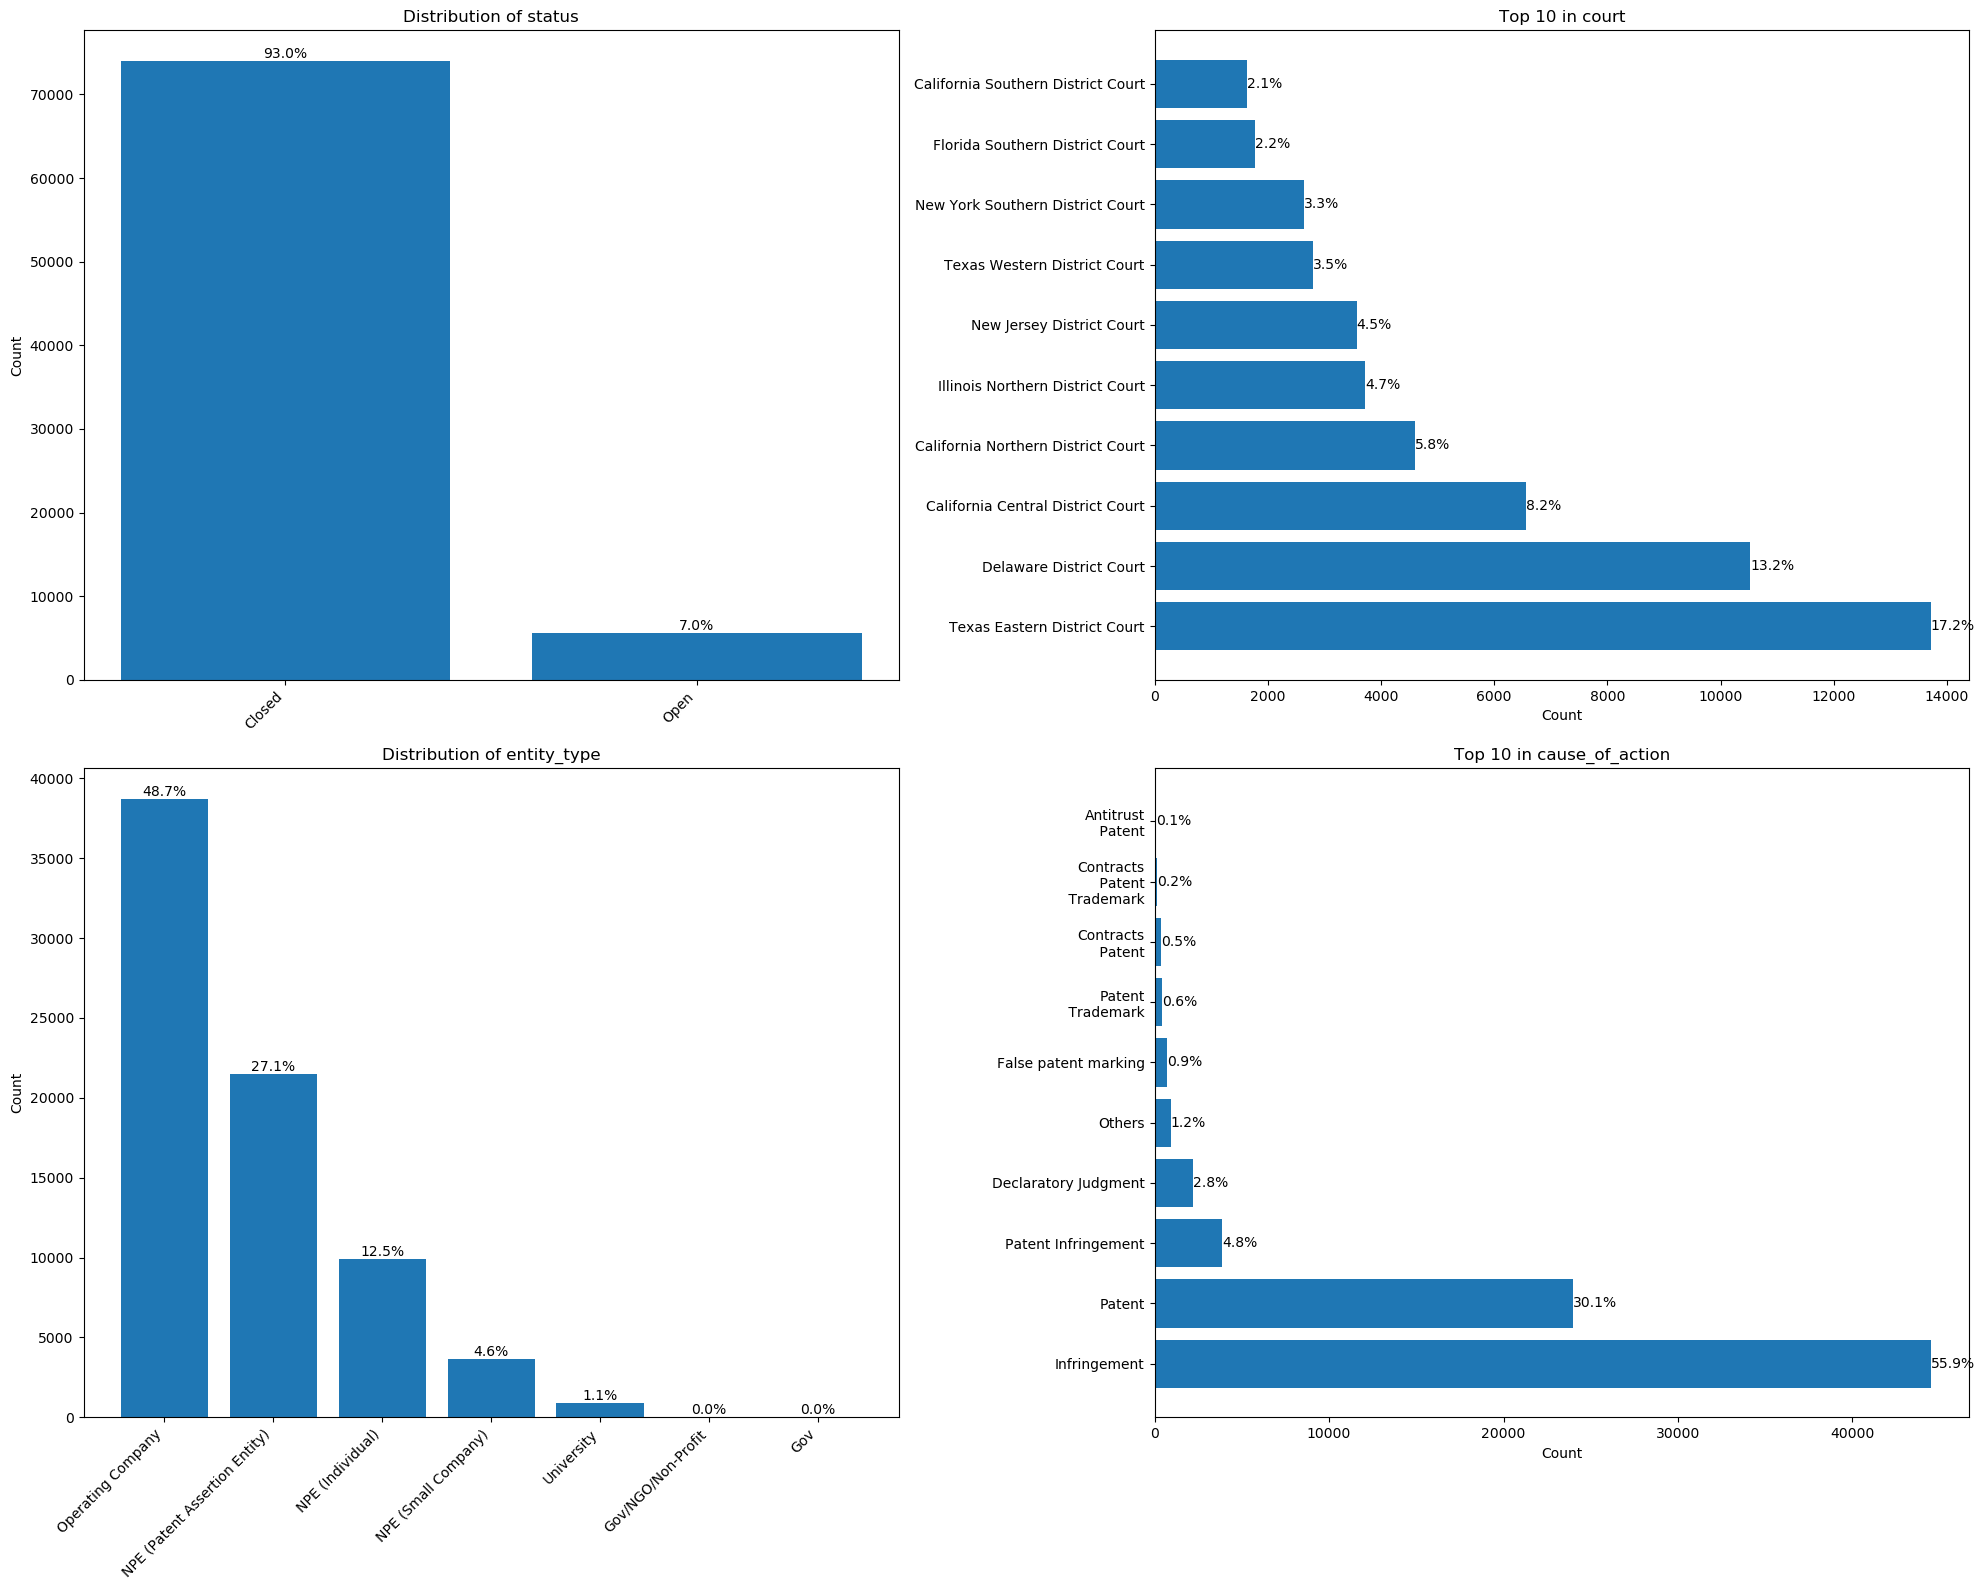

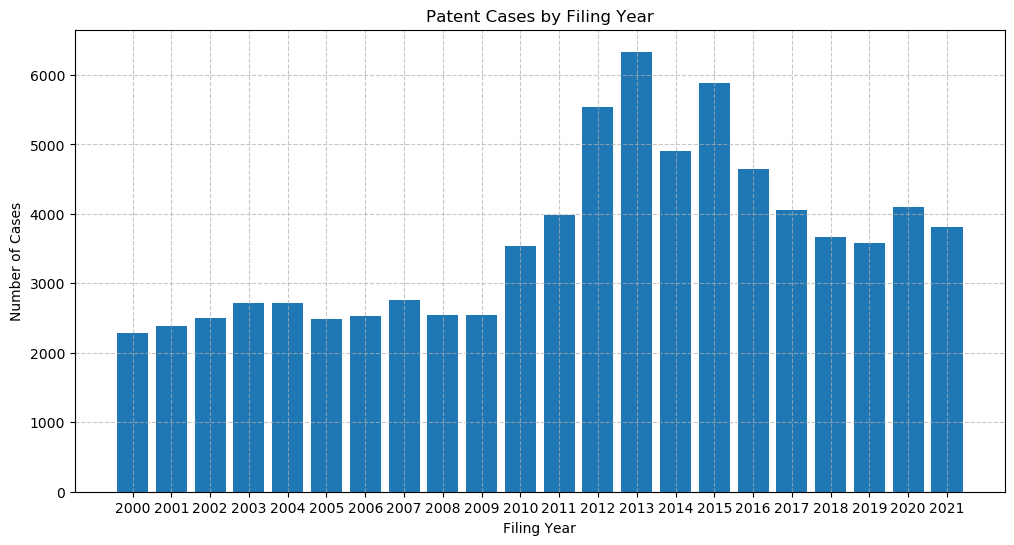

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def analyze_patent_data_bias(df):
    """
    Analyze potential bias in patent litigation data and visualize distributions
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing patent data
    """
    print(f"Starting analysis on provided DataFrame. Shape: {df.shape}")
    
    # 1. BASIC DATA QUALITY CHECK
    print("\n--- DATA QUALITY CHECK ---")
    null_percentages = (df.isnull().sum() / len(df) * 100).round(2)
    print("\nMissing values percentage by column:")
    print(null_percentages[null_percentages > 0])
    
    # 2. ANALYZE CATEGORICAL DISTRIBUTIONS
    print("\n--- CATEGORICAL DISTRIBUTIONS ---")
    categorical_cols = ['status', 'court', 'entity_type', 'cause_of_action']
    
    fig = plt.figure(figsize=(20, 16))
    
    for i, col in enumerate(categorical_cols, 1):
        if col in df.columns:
            if df[col].nunique() > 0:
                # Calculate distribution
                value_counts = df[col].value_counts()
                
                # Display distribution
                print(f"\nDistribution of {col}:")
                percentage = (value_counts / len(df) * 100).round(2)
                dist_df = pd.DataFrame({'count': value_counts, 'percentage': percentage})
                print(dist_df)
                
                # Plot distribution using basic matplotlib (no seaborn)
                ax = fig.add_subplot(2, 2, i)
                
                if df[col].nunique() <= 10:
                    # For few categories, use bar plot
                    bars = ax.bar(range(len(value_counts)), value_counts.values)
                    ax.set_xticks(range(len(value_counts)))
                    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
                    ax.set_title(f'Distribution of {col}')
                    ax.set_ylabel('Count')
                    
                    # Add percentages on top of bars
                    for j, bar in enumerate(bars):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                                f"{percentage.iloc[j]:.1f}%",
                                ha='center', va='bottom')
                else:
                    # For many categories, use horizontal bar plot with top N
                    top_n = min(10, df[col].nunique())
                    top_values = value_counts.head(top_n)
                    
                    bars = ax.barh(range(len(top_values)), top_values.values)
                    ax.set_yticks(range(len(top_values)))
                    ax.set_yticklabels(top_values.index)
                    ax.set_title(f'Top {top_n} in {col}')
                    ax.set_xlabel('Count')
                    
                    # Add percentages at end of bars
                    for j, bar in enumerate(bars):
                        width = bar.get_width()
                        ax.text(width, bar.get_y() + bar.get_height()/2,
                                f"{percentage.iloc[j]:.1f}%",
                                ha='left', va='center')
    
    plt.tight_layout()
    plt.savefig('categorical_distributions.png')
    print("\nCategorical distributions plot saved as 'categorical_distributions.png'")
    
    # 3. TIME SERIES ANALYSIS (if filing_year exists)
    if 'filing_year' in df.columns:
        print("\n--- TIME SERIES ANALYSIS ---")
        
        # Check if filing_year is a valid numeric type
        if pd.api.types.is_numeric_dtype(df['filing_year']):
            # Convert to string to ensure it works as a categorical variable
            year_counts = df['filing_year'].astype(str).value_counts().sort_index()
            
            plt.figure(figsize=(12, 6))
            
            # Fixed plotting - convert to lists to avoid potential index issues
            years = list(year_counts.index)
            counts = list(year_counts.values)
            
            plt.bar(years, counts)
            plt.title('Patent Cases by Filing Year')
            plt.xlabel('Filing Year')
            plt.ylabel('Number of Cases')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.savefig('cases_by_year.png')
            print("\nTime series plot saved as 'cases_by_year.png'")
        else:
            print("Warning: filing_year is not numeric, skipping time series analysis")
    
    # 4. ENTITY TYPE ANALYSIS
    if 'entity_type' in df.columns:
        print("\n--- ENTITY TYPE ANALYSIS ---")
        
        
       
    return

# Example usage
if __name__ == "__main__":
    # Assuming clean_data_patent already exists as a DataFrame
    # If you need to load it from a file, uncomment these lines:
    # clean_data_patent = pd.read_csv("your_local_file.csv")
    
    # Run the analysis on the existing DataFrame
    analyze_patent_data_bias(clean_data_patent)


Chart for Texas Eastern District Court saved as 'court_1_Texas_Eastern_District_Court_pct.png'
Chart for Delaware District Court saved as 'court_2_Delaware_District_Court_pct.png'
Chart for California Central District Court saved as 'court_3_California_Central_District_Court_pct.png'
Chart for California Northern District Court saved as 'court_4_California_Northern_District_Court_pct.png'
Chart for Illinois Northern District Court saved as 'court_5_Illinois_Northern_District_Court_pct.png'


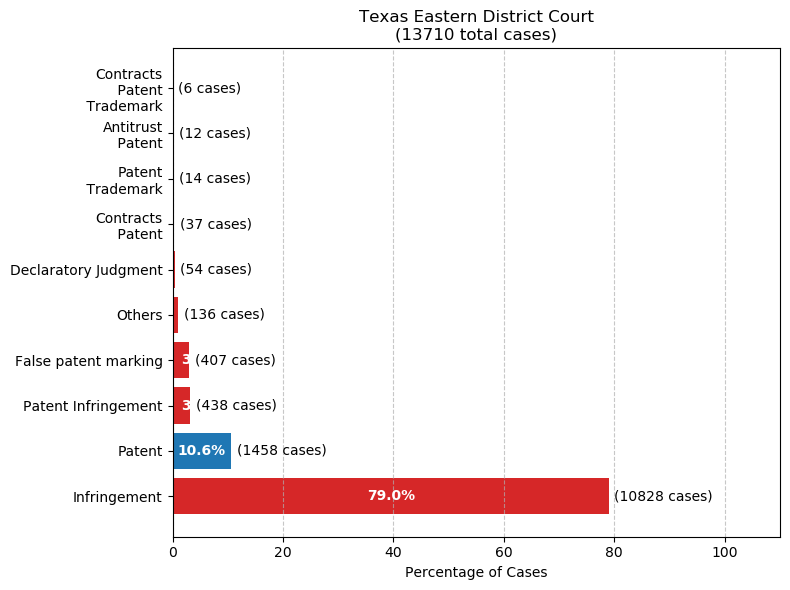

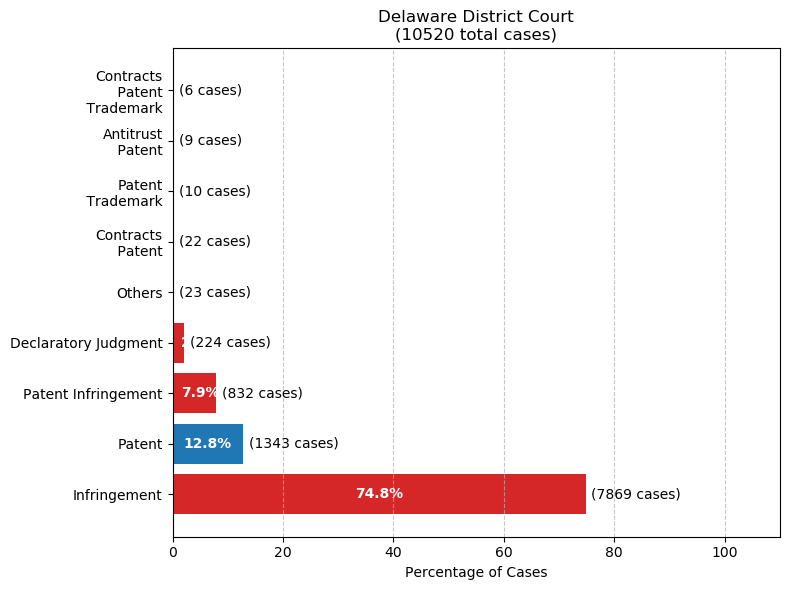

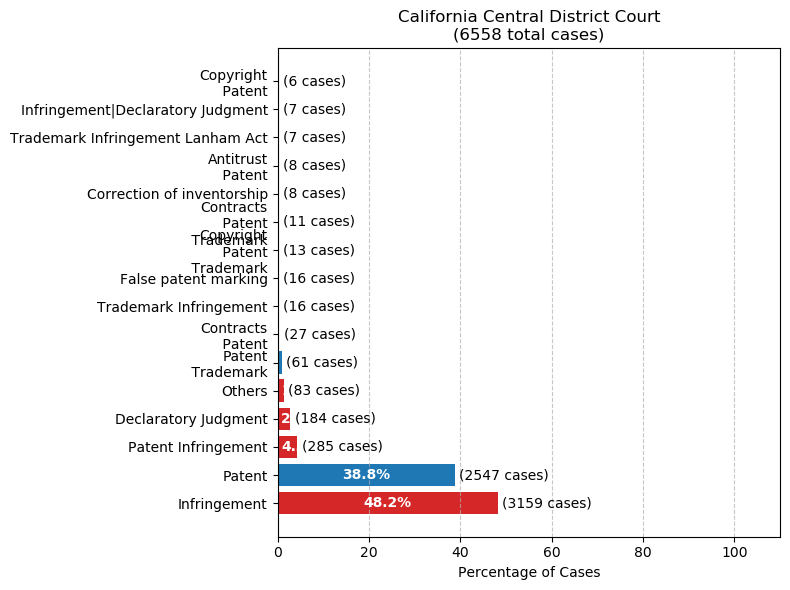

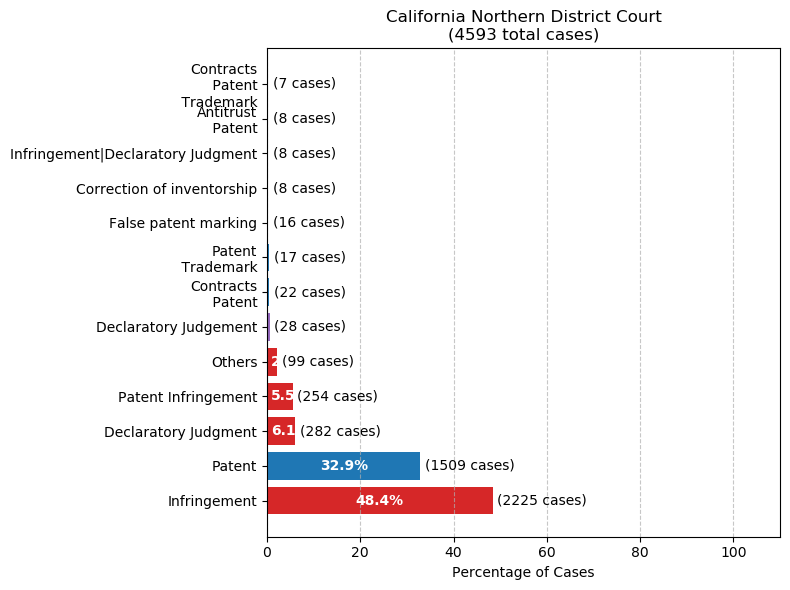

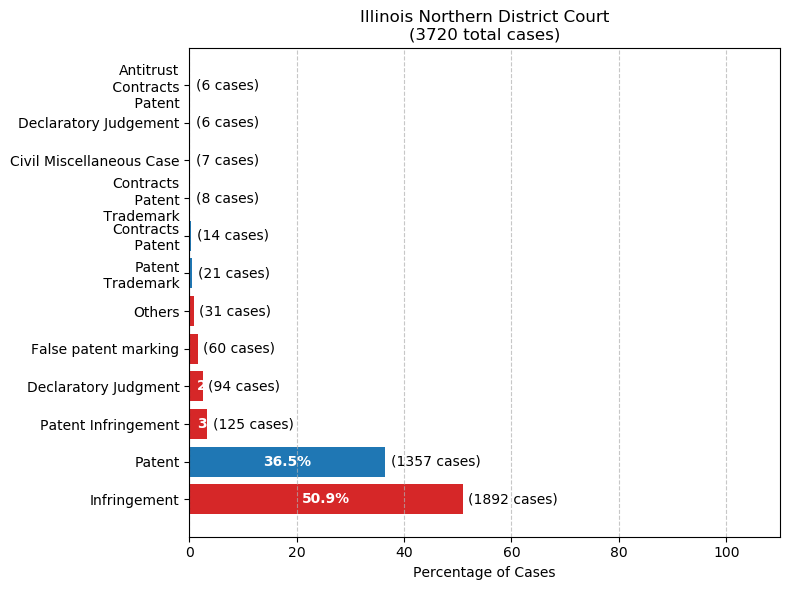

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_court_percentage_charts(df, top_n=5, min_cases=5):
    
    # Get the top courts by case count
    top_courts = df['court'].value_counts().head(top_n).index.tolist()
    
    # Create color map for consistent colors across charts
    unique_causes = df['cause_of_action'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_causes)))
    color_map = {cause: colors[i] for i, cause in enumerate(unique_causes)}
    
    # Create a separate chart for each of the top courts
    for i, court in enumerate(top_courts):
        # Filter data for this court
        court_data = df[df['court'] == court].copy()
        
        # Get cause of action distribution
        cause_counts = court_data['cause_of_action'].value_counts()
        
        # Filter to only include causes with more than 'min_cases' cases
        cause_counts = cause_counts[cause_counts > min_cases]
        
        if cause_counts.empty:
            print(f"No causes with more than {min_cases} cases for {court}. Skipping.")
            continue
        
        cause_pcts = (cause_counts / len(court_data) * 100).round(1)
        
        # Create figure
        plt.figure(figsize=(8, 6))
        
        # Create percentage bar chart
        y_pos = range(len(cause_pcts))
        bars = plt.barh(y_pos, cause_pcts.values, 
                        color=[color_map[cause] for cause in cause_pcts.index])
        
        # Add percentage labels inside bars
        for j, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(max(5, width/2), bar.get_y() + bar.get_height()/2,
                     f"{width}%", ha='center', va='center', 
                     color='white', fontweight='bold')
            
            # Add count at the right end of each bar
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                     f"({cause_counts.iloc[j]} cases)", 
                     ha='left', va='center')
        
        # Set ticks and labels
        plt.yticks(y_pos, cause_pcts.index)
        
        # Set limits to ensure consistency across charts - maximum 110%
        plt.xlim(0, 110)
        
        # Add title and labels
        plt.title(f"{court}\n({len(court_data)} total cases)", fontsize=12)
        plt.xlabel("Percentage of Cases", fontsize=10)
        
        # Add grid for easier reading
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Tight layout
        plt.tight_layout()
        
        # Save the figure
        clean_name = court.replace(' ', '_').replace(',', '').replace('.', '')
        plt.savefig(f"court_{i+1}_{clean_name}_pct.png", dpi=300)
        print(f"Chart for {court} saved as 'court_{i+1}_{clean_name}_pct.png'")
    

# Example usage:
create_court_percentage_charts(clean_data_patent)
